<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_3g_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Erased some of the training output for version 3.1 to keep size of notebook manageable.

**3.1g** - Now that the autoencoder seems to be close to overfitting the training data, I'm going to try to add an adversarial network to it to see how that works.

Updated training function so that it uses inputs and reconstructions from different batches rather than using the reconstructed and real versions of the same images for each batch. A side effect of this is that the discriminator is trained at most once every other iteration.

20190701 - Added code to only train discriminator when it's accuracy is below a certain threshold. It was getting tiring trying to tune the training so that one wouldn't overload the other one. We'll see how this works.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [2]:
# !gsutil cp gs://{bucket_name}/model_30_trained.pt ./model_3g_e.pt
!gsutil cp gs://{bucket_name}/model_3g_e1.pt ./model_3g_e.pt
!gsutil cp gs://{bucket_name}/disc_model_3_e1.pt ./disc_model_3_e.pt

Copying gs://pneumonia/model_3g_e1.pt...
\ [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    
Copying gs://pneumonia/disc_model_3_e1.pt...
| [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [3]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
- [1 files][  1.2 GiB/  1.2 GiB]   35.9 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [4]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

--2019-07-27 05:42:18--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.155.5
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.155.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073596 (1.0M) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>]   1.02M   678KB/s    in 1.5s    

2019-07-27 05:42:20 (678 KB/s) - ‘Training_Pictures.zip’ saved [1073596/1073596]



In [5]:
# if not os.path.exists("imdb_images3.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
#   zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()

if not os.path.exists("GWB_200x200_JPEG.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
  zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
  zip_ref.extractall('data/images')               
  zip_ref.close()  

--2019-07-27 05:42:24--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.5
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15795698 (15M) [application/zip]
Saving to: ‘GWB_200x200_JPEG.zip’

GWB_200x200_JPEG.zi 100%[===================>]  15.06M  5.15MB/s    in 2.9s    

2019-07-27 05:42:28 (5.15 MB/s) - ‘GWB_200x200_JPEG.zip’ saved [15795698/15795698]



In [6]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("faces96.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
  zip_ref = zipfile.ZipFile('faces96.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("crop_part1.tar.gz"):
  !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
  !tar -xf crop_part1.tar.gz -C data/images

Copying gs://pneumonia/wiki_images2.zip...
\ [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
--2019-07-27 05:42:48--  https://cswww.essex.ac.uk/mv/allfaces/faces96.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21040168 (20M) [application/zip]
Saving to: ‘faces96.zip’

faces96.zip         100%[===================>]  20.07M  5.61MB/s    in 3.6s    

2019-07-27 05:42:53 (5.61 MB/s) - ‘faces96.zip’ saved [21040168/21040168]

--2019-07-27 05:42:56--  https://cswww.essex.ac.uk/mv/allfaces/faces95.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6425534 (6.1M) 

In [0]:
BATCH_SIZE = 14
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.075,0.075), scale=(0.9,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

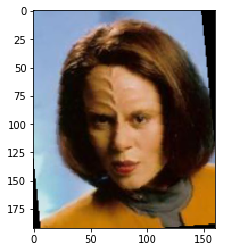

In [0]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

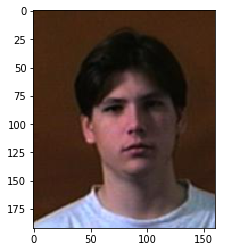

In [0]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 212885
    Root location: data/images

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 20221
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Create Models

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None, d_faked=None, debug=False, autoweight=False):
    beta_mse = 150.0
    beta_kld = 0.1
    beta_gloss = 1.0
    
    total_loss = 0
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        ones = torch.ones(d_faked.shape[0]).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
    else:
        g_loss = torch.zeros(1)
    
    # if we are autoweighting we want to make sure that the MSE loss is greater than the XE loss
    if autoweight:
        mse_weight = (g_loss / MSE) * 3.0 * MSE
        total_loss = (MSE * mse_weight) + g_loss
    else:
        total_loss = (MSE * beta_mse) + (g_loss * beta_gloss)
    
    # variational loss IF we are doing variational
    if mu is not None and logvar is not None:
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) 
        total_loss += (KLD * beta_kld)
    else:
        KLD = torch.zeros(1)
        
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", total_loss)
    
    return total_loss, MSE * beta_mse, KLD * beta_kld, g_loss * beta_gloss
  
def disc_loss(d_true, d_faked):
    ones = torch.ones(d_true.shape[0]).cuda()
    zeros = torch.zeros(d_true.shape[0]).cuda()
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake

    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=None, print_metrics=1000, extra_gen_train=2, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt"):
    
    # if we aren't training the generator we don't need to train the discriminator less than every epoch
    if train_gen is False:
      extra_gen_train = 1
      
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          mse_loss = 0
          kld_loss = 0
          disc_losses = 0
          
          d_tr_loss = 0.0
          g_tr_loss = 0.0
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_loss = 0.0
          test_d_loss = 0
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          
          for i, (inputs, _) in enumerate(train_loader):
              if inputs.shape[0] == 1:
                continue
                
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              d_optimizer.zero_grad()
              g_optimizer.zero_grad()
              
              # generate our fake images
              if train_gen:
                  recon, code, logvar = generator(inputs)
              else:
                with torch.no_grad():
                    recon, code, logvar = generator(inputs)
              
              # concat half of the real images and half of the recons for the discriminator batch
              # it should be different halves
              batch_size = inputs.shape[0] // 2
              disc_batch = torch.cat((inputs[:batch_size], recon[batch_size:]), 0)
              
              # feed the batch to the discriminator
              d_logits = discriminator(disc_batch)
              
              if use_cuda:
                  ones = torch.ones(batch_size).cuda()
                  zeros = torch.zeros(batch_size).cuda()
              else:
                  ones = torch.ones(batch_size)
                  zeros = torch.zeros(batch_size)

              labels = torch.cat((ones, zeros))
              d_loss = disc_loss2(labels, d_logits)
              
              # calculate the accuracy of our discriminator
              d_preds = torch.sigmoid(d_logits).round()
              
              d_accuracy = torch.mean((d_preds == labels).double())
              batch_accuracies.append(d_accuracy.item())
              
              # update the discriminator every other step to give the generator time to catch up
              if train_disc and (np.mean(batch_accuracies) <= 0.80 or d_accuracy.item() <= 0.75):
                d_loss.backward(retain_graph=True)
                d_optimizer.step()
                d_optimizer.zero_grad()
              
              # feed the reconstructed images into the discriminator for the generator loss
              faked_logits = discriminator(recon)
                
              # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
              if train_gen:
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
              else:
                with torch.no_grad():
                  g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
              
              g_tr_loss += g_loss.item()
              mse_loss += mse.item()
              kld_loss += kld.item()
              disc_losses += disc_loss.item()
              
              d_tr_loss += d_loss.item()
              batch_losses.append(g_loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", disc_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print("Inputs:", inputs.shape)
                  print("Recon:", recon.shape)
                  print("Error plotting images:", e)

              torch.save(discriminator.state_dict(), d_save_path)
              torch.save(generator.state_dict(), g_save_path)
          
          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                test_loss += loss.item()
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
                d_preds = torch.sigmoid(d_logits).round()
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "MSE Loss:", mse_loss, "KLD Loss:", kld_loss, "GAN XE Loss:", disc_losses,"Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    except ValueError as e:
      print("Value error... Saving model...")
      print(e)
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      
# try to train so that we aren't using the real and fake versions of the same images for each batch 
# maybe that will improve the discriminator?
def train_discriminator3(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=None, print_metrics=1000, extra_gen_train=2, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_7.pt", g_save_path="gen_model_7_var.pt"):
    
    # if we aren't training the generator we don't need to train the discriminator less than every epoch
    if train_gen is False:
        extra_gen_train = 1
      
    try:
        for epoch in range(num_epochs):
            discriminator.train()
            generator.train()
            
            # generate unique names for the model based on the epoch so we have backups
            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 

            # initialize our metrics
            mse_loss = 0
            kld_loss = 0
            disc_losses = 0

            d_tr_loss = 0.0
            g_tr_loss = 0.0
            d_test_loss = 0.0
            g_test_loss = 0.0
            test_loss = 0.0
            test_d_loss = 0

            test_d_acc = []
            batch_losses = []
            batch_accuracies = []
            
            # loop through the data loader
            for i, (inputs, _) in enumerate(train_loader):
                if inputs.shape[0] <= 5:
                    continue
                    
                # if we are using CUDA copy the inputs to it
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                # zero out the gradients
                d_optimizer.zero_grad()
                g_optimizer.zero_grad()
               
                # generate our reconstructed images
                if train_gen:
                    recon, code, logvar = generator(inputs)
                else:
                    with torch.no_grad():
                        recon, code, logvar = generator(inputs)
                
                # if we are in an even iteration we only train the generator
                # so we use ones as the label
                if i % 2 == 0:
                    # copy them to the CPU to save RAM
                    disc_batch = inputs.clone().cpu()
                    
                    # feed the batch to the discriminator
                    faked_logits = discriminator(inputs)
                
                # if we are in an odd iteration we train both the discriminator
                # and the generator so we use the true labels
                else:
                    # concat the previous disc batch with the reconstructed images
                    input_shape = disc_batch.shape[0]
                    disc_batch = torch.cat((disc_batch.cuda(), recon), 0)
                    
                    # feed the batch to the discriminator
                    d_logits = discriminator(disc_batch)
                    
                    # separate the fake logits back out so we can feed them to the gen loss function
                    faked_logits = d_logits[recon.shape[0]:]
                    
                    batch_size = recon.shape[0]
                    if use_cuda:
                        ones = torch.ones(input_shape).cuda()
                        zeros = torch.zeros(batch_size).cuda()
                    else:
                        ones = torch.ones(input_shape)
                        zeros = torch.zeros(batch_size)
                    labels = torch.cat((ones, zeros))
                    
                    d_logits = discriminator(disc_batch)
                    d_loss = disc_loss2(labels, d_logits)
                    d_tr_loss += d_loss.item()
                    
                    # calculate the accuracy of our discriminator
                    d_preds = torch.sigmoid(d_logits).round()

                    d_accuracy = torch.mean((d_preds == labels).float())
                    batch_accuracies.append(d_accuracy.item())
                    
                    # update the discriminator every other step to give the generator time to catch up
                    if train_disc and (np.mean(batch_accuracies) <= 0.85 or d_accuracy.item() <= 0.75):
                        d_loss.backward(retain_graph=True)
                        d_optimizer.step()

                # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
                if train_gen:
                    g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                    g_loss.backward()
                    g_optimizer.step()
                else:
                    with torch.no_grad():
                        g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)

                g_tr_loss += g_loss.item()
                mse_loss += mse.item()
                kld_loss += kld.item()
                disc_losses += disc_loss.item()

                batch_losses.append(g_loss.item())
            
                if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                    print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", disc_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

                if i % plot_images == 0 and i > 0:
                    fig, ax = plt.subplots(1, 2, figsize=(6,6))
                    ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    plt.show()
          
            if epoch % display_images == 0:
                # plot a few random images
                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6,6))
                    fig.suptitle("Training Images")
                    ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                    ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                    plt.show()
                except Exception as e:
                    print("Inputs:", inputs.shape)
                    print("Recon:", recon.shape)
                    print("Error plotting images:", e)

                torch.save(discriminator.state_dict(), d_save_path)
                torch.save(generator.state_dict(), g_save_path)

            if test_loader is not None:
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    for i, (inputs, _) in enumerate(test_loader):
                        if use_cuda and torch.cuda.is_available():
                            inputs = inputs.cuda()

                        # autoencode the input images
                        recon, code, logvar = generator(inputs)

                        loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                        test_loss += loss.item()

                        # combine the real and recon images into a single batch for the discriminator
                        disc_batch = torch.cat((inputs, recon), 0)

                        # feed the batch to the discriminator
                        d_logits = discriminator(disc_batch)

                        # create labels for the disc loss function
                        batch_size = d_logits.shape[0] // 2
                        if use_cuda:
                            ones = torch.ones(batch_size).cuda()
                            zeros = torch.zeros(batch_size).cuda()
                        else:
                            ones = torch.ones(batch_size)
                            zeros = torch.zeros(batch_size)

                        labels = torch.cat((ones, zeros))

                        # run the discriminator loss function
                        d_loss = disc_loss2(labels, d_logits)
                        test_d_loss += d_loss.item()

                        # calculate the accuracy of our discriminator
                        d_preds = torch.sigmoid(d_logits).round()
                        d_accuracy = torch.mean((d_preds == labels).double())
                        test_d_acc.append(d_accuracy.item())

                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6,6))
                    fig.suptitle("Test Images")
                    ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                    ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                    plt.show()
                except Exception as e:
                    print(e)
                  
            print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "MSE Loss:", mse_loss, "KLD Loss:", kld_loss, "GAN XE Loss:", disc_losses,"Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))

            epoch_list.append(epoch)

            if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                g_scheduler.step()

            if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                d_scheduler.step()
 
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return 
    except ValueError:
        print("Value error occurred!")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return 

    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_6.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          test_loss = 0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss, _, _, _ = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=None)

                test_loss += loss.item()

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", tr_loss, "Test Loss:", test_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
            self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
            logvar = self.fc2(concat)
        else:
            logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 48, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # block 2
        self.conv4 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(96)
        
        # block 3
        self.conv7 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(192)
        self.conv9 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(192)
        
        # block 4
        self.conv10 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(384)
        self.conv11 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(384)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Conv2d(1024, 2048, 1) # code layer
        self.bn14 = nn.BatchNorm2d(2048)
        self.fc2 = nn.Conv2d(2048, 1, 1)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.bn14(self.fc1(gap))))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [11]:
from torch import optim
import numpy as np

## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
generator = SingleModel(encoder, decoder)
discriminator = Discriminator()

params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
g_optimizer = optim.Adam(generator.encoder.parameters(), lr=0.0006)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.95)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.95)

try:
  generator.load_state_dict(torch.load("model_3g_e.pt"))
  print("Generator loaded")
except:
  print("Error loading Generator")

try:
    discriminator.load_state_dict(torch.load("disc_model_3_e.pt"))
    print("Discriminator loaded")
except:
    print("Error loading discriminator")

Autoencoder Params: 77289667
Discriminator Params: 11673569
Generator loaded
Discriminator loaded


	Epoch 0 batch 500 gen total loss: 0.9250400066375732 mse loss: 0.38673168420791626 kld loss: 0.0 xe loss: 0.538308322429657 disc loss: 0.08458853513002396 disc acc: 0.935753493013972
	Epoch 0 batch 1000 gen total loss: 0.9097557067871094 mse loss: 0.38731473684310913 kld loss: 0.0 xe loss: 0.5224409699440002 disc loss: 0.06303858011960983 disc acc: 0.9502997002997003
	Epoch 0 batch 1500 gen total loss: 0.7277157306671143 mse loss: 0.2870851457118988 kld loss: 0.0 xe loss: 0.44063055515289307 disc loss: 0.0531747080385685 disc acc: 0.9659810126582279
	Epoch 0 batch 2000 gen total loss: 0.7865495681762695 mse loss: 0.3374318480491638 kld loss: 0.0 xe loss: 0.4491177201271057 disc loss: 0.06315121799707413 disc acc: 0.9734820089955023
	Epoch 0 batch 2500 gen total loss: 0.7587977647781372 mse loss: 0.2897101640701294 kld loss: 0.0 xe loss: 0.4690876305103302 disc loss: 0.05981794372200966 disc acc: 0.9778838464614155
	Epoch 0 batch 3000 gen total loss: 0.8223934173583984 mse loss: 0.3982

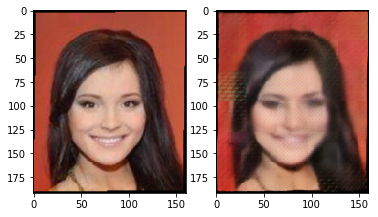

	Epoch 0 batch 4500 gen total loss: 0.8456664681434631 mse loss: 0.39177918434143066 kld loss: 0.0 xe loss: 0.45388728380203247 disc loss: 0.10067413747310638 disc acc: 0.9853088202621639
	Epoch 0 batch 5000 gen total loss: 0.7437014579772949 mse loss: 0.2976638376712799 kld loss: 0.0 xe loss: 0.446037620306015 disc loss: 0.08430833369493484 disc acc: 0.9862277544491101
	Epoch 0 batch 5500 gen total loss: 0.8021242022514343 mse loss: 0.34821802377700806 kld loss: 0.0 xe loss: 0.45390617847442627 disc loss: 0.0792374312877655 disc acc: 0.9869682784948192
	Epoch 0 batch 6000 gen total loss: 0.7710793614387512 mse loss: 0.36212092638015747 kld loss: 0.0 xe loss: 0.40895843505859375 disc loss: 0.06511829793453217 disc acc: 0.9875541576403932
	Epoch 0 batch 6500 gen total loss: 0.7927001714706421 mse loss: 0.34182000160217285 kld loss: 0.0 xe loss: 0.45088016986846924 disc loss: 0.10926447063684464 disc acc: 0.9881172127365021
	Epoch 0 batch 7000 gen total loss: 0.8730867505073547 mse loss:

	Epoch 0 batch 8500 gen total loss: 0.7232063412666321 mse loss: 0.3052240014076233 kld loss: 0.0 xe loss: 0.4179823398590088 disc loss: 0.07518597692251205 disc acc: 0.9893615457005058
	Epoch 0 batch 9000 gen total loss: 0.7172714471817017 mse loss: 0.3142693340778351 kld loss: 0.0 xe loss: 0.4030021131038666 disc loss: 0.09955666214227676 disc acc: 0.9896192089767804
	Epoch 0 batch 9500 gen total loss: 0.6608774662017822 mse loss: 0.28190720081329346 kld loss: 0.0 xe loss: 0.3789702355861664 disc loss: 0.08840245008468628 disc acc: 0.9898760656772971
	Epoch 0 batch 10000 gen total loss: 0.7684645652770996 mse loss: 0.3166646361351013 kld loss: 0.0 xe loss: 0.4517999589443207 disc loss: 0.07920888066291809 disc acc: 0.98997600239976
	Epoch 0 batch 10500 gen total loss: 0.7593045830726624 mse loss: 0.33964329957962036 kld loss: 0.0 xe loss: 0.419661283493042 disc loss: 0.1257612705230713 disc acc: 0.9901259403866298
	Epoch 0 batch 11000 gen total loss: 0.8214137554168701 mse loss: 0.34

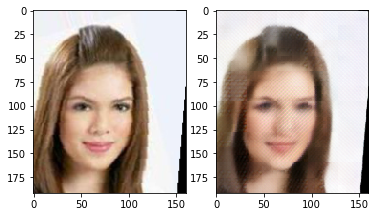

	Epoch 0 batch 12500 gen total loss: 0.7278525233268738 mse loss: 0.3289249837398529 kld loss: 0.0 xe loss: 0.3989275395870209 disc loss: 0.13636328279972076 disc acc: 0.990435765138789
	Epoch 0 batch 13000 gen total loss: 0.760076642036438 mse loss: 0.32999807596206665 kld loss: 0.0 xe loss: 0.43007856607437134 disc loss: 0.09152676165103912 disc acc: 0.9905055380355358
Value error... Saving model...
Target size (torch.Size([4])) must be the same as input size (torch.Size([5]))
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads suc

In [0]:
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=1, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=500, extra_gen_train=1, plot_images=4000, display_images=2000, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

	Epoch 2 batch 1000 gen total loss: 1.1377043724060059 mse loss: 0.5908114314079285 kld loss: 0.0 xe loss: 0.5468929409980774 disc loss: 0.2823196053504944 disc acc: 0.9569716426087069
	Epoch 2 batch 2000 gen total loss: 1.0379917621612549 mse loss: 0.5669148564338684 kld loss: 0.0 xe loss: 0.4710768461227417 disc loss: 0.18305353820323944 disc acc: 0.9572000142330233
	Epoch 2 batch 3000 gen total loss: 0.9549024701118469 mse loss: 0.4246870279312134 kld loss: 0.0 xe loss: 0.5302154421806335 disc loss: 0.21466310322284698 disc acc: 0.9574666015682162
	Epoch 2 batch 4000 gen total loss: 1.021550178527832 mse loss: 0.47981902956962585 kld loss: 0.0 xe loss: 0.5417311787605286 disc loss: 0.1833941787481308 disc acc: 0.9571536115387683


	Epoch 2 batch 5000 gen total loss: 0.8662662506103516 mse loss: 0.38829582929611206 kld loss: 0.0 xe loss: 0.4779703915119171 disc loss: 0.2101491540670395 disc acc: 0.9573228639457207
	Epoch 2 batch 6000 gen total loss: 0.882424533367157 mse loss: 0.4250677525997162 kld loss: 0.0 xe loss: 0.4573567807674408 disc loss: 0.1974971443414688 disc acc: 0.958102263888902
	Epoch 2 batch 7000 gen total loss: 1.0058497190475464 mse loss: 0.5151013731956482 kld loss: 0.0 xe loss: 0.4907483458518982 disc loss: 0.21916615962982178 disc acc: 0.9591385332965677
	Epoch 2 batch 8000 gen total loss: 0.8894031047821045 mse loss: 0.4466971755027771 kld loss: 0.0 xe loss: 0.4427059590816498 disc loss: 0.13014625012874603 disc acc: 0.9596747264225041


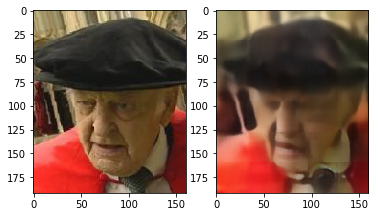

	Epoch 2 batch 9000 gen total loss: 0.8832206726074219 mse loss: 0.3874504566192627 kld loss: 0.0 xe loss: 0.4957702159881592 disc loss: 0.22103334963321686 disc acc: 0.960607594484396
	Epoch 2 batch 10000 gen total loss: 0.8428317904472351 mse loss: 0.38621821999549866 kld loss: 0.0 xe loss: 0.45661357045173645 disc loss: 0.18728454411029816 disc acc: 0.960825388989065
	Epoch 2 batch 11000 gen total loss: 1.0624160766601562 mse loss: 0.5309606790542603 kld loss: 0.0 xe loss: 0.531455397605896 disc loss: 0.26946818828582764 disc acc: 0.9610685172576534
	Epoch 2 batch 12000 gen total loss: 0.8936601877212524 mse loss: 0.408550500869751 kld loss: 0.0 xe loss: 0.48510968685150146 disc loss: 0.22222822904586792 disc acc: 0.9616163368678701


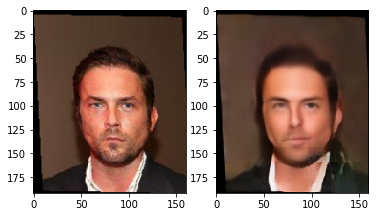

	Epoch 2 batch 13000 gen total loss: 0.9795328974723816 mse loss: 0.4749968647956848 kld loss: 0.0 xe loss: 0.5045360326766968 disc loss: 0.1260749101638794 disc acc: 0.9627171966623558
	Epoch 2 batch 14000 gen total loss: 0.8575447797775269 mse loss: 0.4010586440563202 kld loss: 0.0 xe loss: 0.4564861059188843 disc loss: 0.12798915803432465 disc acc: 0.9634873449986522
	Epoch 2 batch 15000 gen total loss: 0.9456131458282471 mse loss: 0.45499956607818604 kld loss: 0.0 xe loss: 0.49061354994773865 disc loss: 0.15677320957183838 disc acc: 0.9643548004119112
index 1 is out of bounds for dimension 0 with size 1


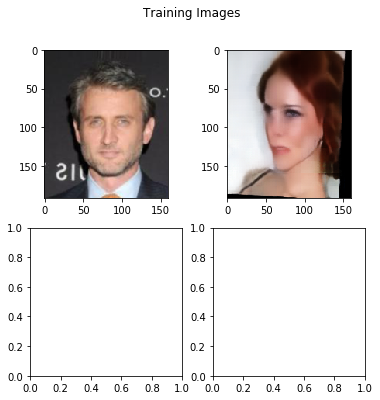

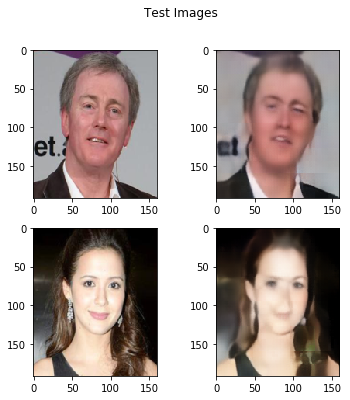

Epoch: 2 Gen Train Loss: 14442.903928339481 MSE Loss: 6890.460651218891 KLD Loss: 0.0 GAN XE Loss: 7552.443279564381 Disc Train Loss: 2747.45760460943 Test Loss: 383.09884509444237 Avg Tr Disc Acc: 0.9645253244915338 Avg Te Disc Acc: 0.9891465585384094
	Epoch 3 batch 1000 gen total loss: 1.0049209594726562 mse loss: 0.5295795202255249 kld loss: 0.0 xe loss: 0.47534146904945374 disc loss: 0.10344459116458893 disc acc: 0.9751677330467965
	Epoch 3 batch 2000 gen total loss: 0.9620060920715332 mse loss: 0.4562295973300934 kld loss: 0.0 xe loss: 0.5057765245437622 disc loss: 0.08718690276145935 disc acc: 0.975191019535035
Interrupting... Saving model...
Copying file://model_3g.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that

In [13]:
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=2, print_metrics=1000, extra_gen_train=1, plot_images=4000, train_gen=True, train_disc=True, test_loader=test_loader, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

	Epoch 0 batch 2000 gen total loss: 0.9808557033538818 mse loss: 0.4525807499885559 kld loss: 0.0 xe loss: 0.5282749533653259 disc loss: 0.18872635066509247 disc acc: 0.956807353403019
	Epoch 0 batch 4000 gen total loss: 0.8569895029067993 mse loss: 0.3664669692516327 kld loss: 0.0 xe loss: 0.490522563457489 disc loss: 0.23781263828277588 disc acc: 0.957314285663136


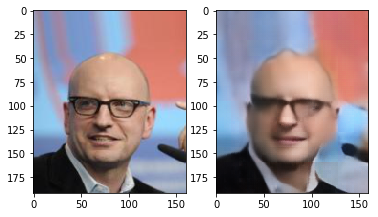

	Epoch 0 batch 6000 gen total loss: 1.08089017868042 mse loss: 0.5940930843353271 kld loss: 0.0 xe loss: 0.486797034740448 disc loss: 0.16860172152519226 disc acc: 0.9564239721005906
	Epoch 0 batch 8000 gen total loss: 0.9722961187362671 mse loss: 0.4558704197406769 kld loss: 0.0 xe loss: 0.5164257287979126 disc loss: 0.1560359001159668 disc acc: 0.9573178780660333


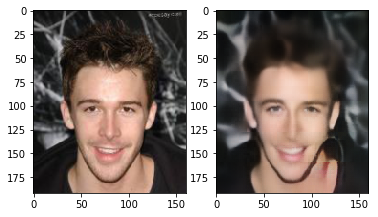

	Epoch 0 batch 10000 gen total loss: 0.851850152015686 mse loss: 0.4017190635204315 kld loss: 0.0 xe loss: 0.4501310884952545 disc loss: 0.12810954451560974 disc acc: 0.9581756538441152
	Epoch 0 batch 12000 gen total loss: 0.9235653877258301 mse loss: 0.4265083372592926 kld loss: 0.0 xe loss: 0.4970570504665375 disc loss: 0.18171216547489166 disc acc: 0.9599974240858439


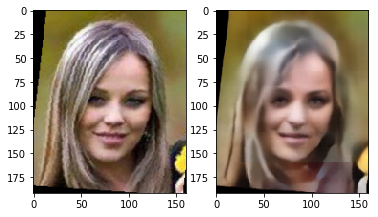

	Epoch 0 batch 14000 gen total loss: 1.0237170457839966 mse loss: 0.3680219054222107 kld loss: 0.0 xe loss: 0.6556951403617859 disc loss: 0.1573721170425415 disc acc: 0.9621302990126964
index 1 is out of bounds for dimension 0 with size 1


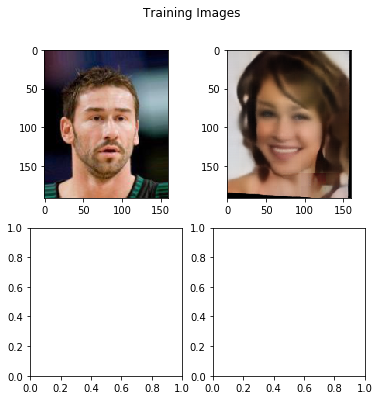

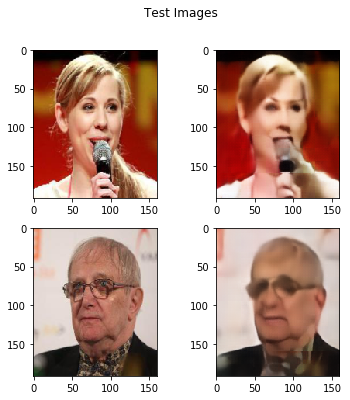

Epoch: 0 Gen Train Loss: 14206.034290492535 MSE Loss: 6676.6784136891365 KLD Loss: 0.0 GAN XE Loss: 7529.35587990284 Disc Train Loss: 2715.6595420464873 Test Loss: 365.127759963274 Avg Tr Disc Acc: 0.9631161062627752 Avg Te Disc Acc: 0.9666681443635798
	Epoch 1 batch 2000 gen total loss: 0.8492401838302612 mse loss: 0.39982274174690247 kld loss: 0.0 xe loss: 0.4494174122810364 disc loss: 0.09667240083217621 disc acc: 0.9735846797759268
	Epoch 1 batch 4000 gen total loss: 0.8828031420707703 mse loss: 0.40436381101608276 kld loss: 0.0 xe loss: 0.4784393310546875 disc loss: 0.1802726835012436 disc acc: 0.9742743321241691


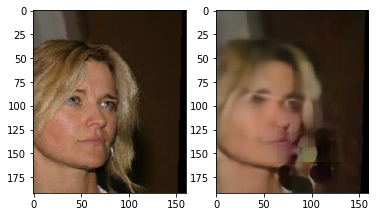

	Epoch 1 batch 6000 gen total loss: 0.9046484231948853 mse loss: 0.43261396884918213 kld loss: 0.0 xe loss: 0.4720344841480255 disc loss: 0.16747233271598816 disc acc: 0.9737782233584485


In [0]:
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=2, print_metrics=2000, extra_gen_train=1, plot_images=4000, train_gen=True, train_disc=True, test_loader=test_loader, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3_e.pt", g_save_path="model_3g_e.pt")

In [0]:
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=2, print_metrics=1000, extra_gen_train=1, plot_images=4000, train_gen=True, train_disc=True, test_loader=test_loader, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

Accuracy: tensor(0.9643, device='cuda:0')
0.0535765215754509


0.8184615969657898


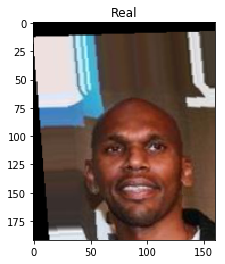

In [19]:
# check that the discriminator is working properly
with torch.no_grad():
    for (inputs, _) in train_loader:
        generator.eval()
        
        recon, mu, logvar = generator(inputs.cuda())
        
        # feed the original images to the discriminator
        real_probs = torch.sigmoid(discriminator(inputs.cuda()))
        fake_probs = torch.sigmoid(discriminator(recon))
        
        probs = torch.cat((real_probs, fake_probs), 0).float()
        labels = torch.cat((torch.ones(inputs.shape[0]), torch.zeros(inputs.shape[0])), 0).cuda()
        
        print("Accuracy:", torch.mean((torch.round(probs) == labels).float()))
        print(fake_probs[0].item())
        plt.imshow(recon[0].cpu().permute(1,2,0))
        plt.title("Recon")
        plt.show()
        
        print(real_probs[0].item())
        plt.imshow(inputs[0].cpu().permute(1,2,0))
        plt.title("Real")
        plt.show()
        
        break

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      recon = generator.decoder(codes)
      d_faked = discriminator(recon)
      print("Faked Logits Mean:", d_faked.mean())
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = d_faked, debug = True)
      break

Mean: tensor(-0.0188, device='cuda:0')
Std: tensor(3.1603, device='cuda:0')
Faked Logits Mean: tensor(0.0726, device='cuda:0')
MSE Loss Raw: tensor(0.0024, device='cuda:0')
MSE Loss Weighted: tensor(0.4753, device='cuda:0')
KLD Loss Raw: tensor([0.])
KLD Loss Weighted: tensor([0.])
Disc Loss Raw: tensor(0.7382, device='cuda:0')
Disc Loss Weighted: tensor(0.1476, device='cuda:0')
Total Loss (weighted): tensor(0.6230, device='cuda:0')


#### Additional Training on Personal Images

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

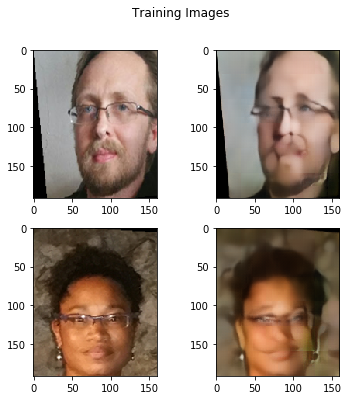

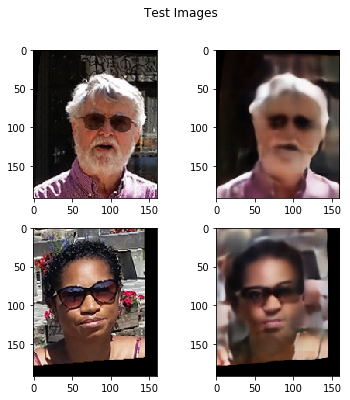

Epoch: 8 Gen Train Loss: 3.678636074066162 MSE Loss: 2.221911370754242 KLD Loss: 0.0 GAN XE Loss: 1.456724613904953 Disc Train Loss: 0.5235447287559509 Test Loss: 2.347195863723755 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 1.0000000447034836


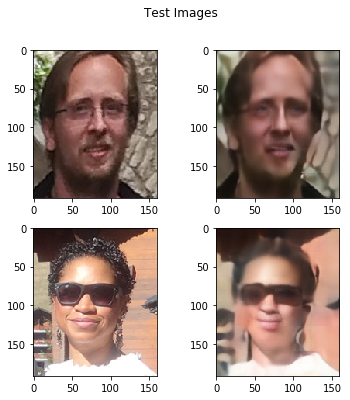

Epoch: 9 Gen Train Loss: 3.794315814971924 MSE Loss: 2.299901068210602 KLD Loss: 0.0 GAN XE Loss: 1.494414746761322 Disc Train Loss: 0.4371633380651474 Test Loss: 2.3279942870140076 Avg Tr Disc Acc: 1.0000000447034836 Avg Te Disc Acc: 1.0000000447034836


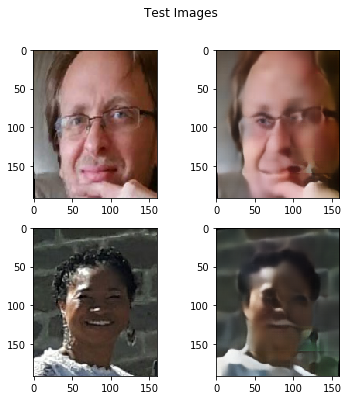

Epoch: 10 Gen Train Loss: 3.704285144805908 MSE Loss: 2.2080002427101135 KLD Loss: 0.0 GAN XE Loss: 1.4962848722934723 Disc Train Loss: 0.5024747401475906 Test Loss: 2.1727561354637146 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 1.0000000447034836


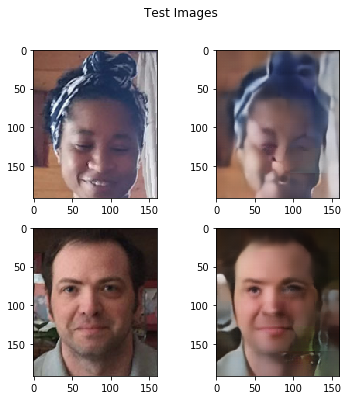

Epoch: 11 Gen Train Loss: 3.803575277328491 MSE Loss: 2.2291566729545593 KLD Loss: 0.0 GAN XE Loss: 1.5744187235832214 Disc Train Loss: 0.4135858193039894 Test Loss: 2.1912921667099 Avg Tr Disc Acc: 1.0000000447034836 Avg Te Disc Acc: 1.0000000447034836


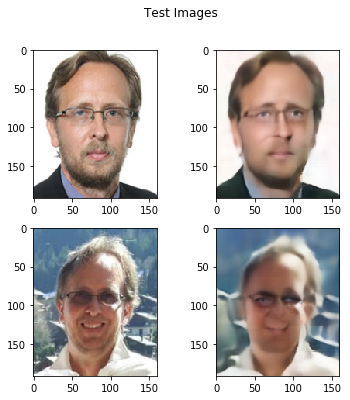

Epoch: 12 Gen Train Loss: 3.6842116117477417 MSE Loss: 2.245888829231262 KLD Loss: 0.0 GAN XE Loss: 1.4383227229118347 Disc Train Loss: 0.5400471389293671 Test Loss: 2.238490581512451 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 1.0000000447034836


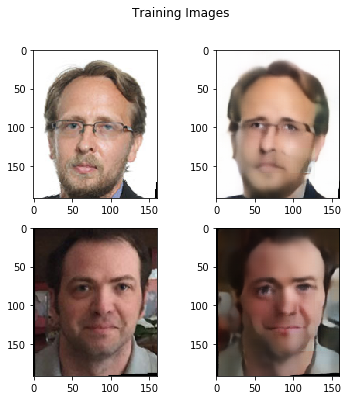

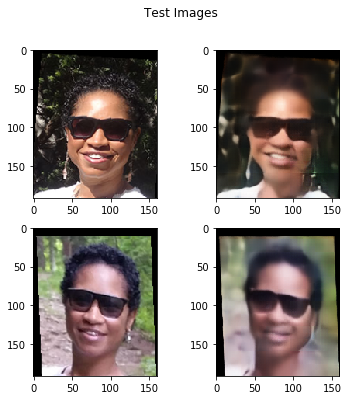

Epoch: 13 Gen Train Loss: 3.7391852140426636 MSE Loss: 2.270864725112915 KLD Loss: 0.0 GAN XE Loss: 1.4683203995227814 Disc Train Loss: 0.5276996940374374 Test Loss: 2.22938996553421 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 0.9880952822665373


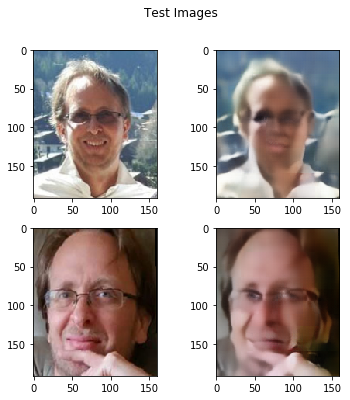

Epoch: 14 Gen Train Loss: 3.9307743310928345 MSE Loss: 2.437800109386444 KLD Loss: 0.0 GAN XE Loss: 1.4929742217063904 Disc Train Loss: 0.6773622035980225 Test Loss: 2.2279741168022156 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 1.0000000447034836


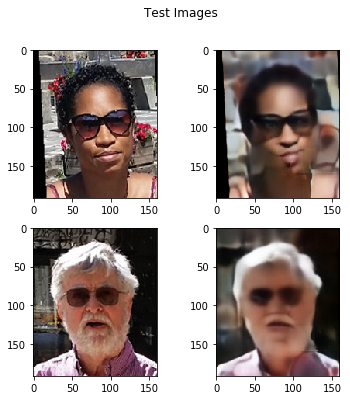

Epoch: 15 Gen Train Loss: 3.7803993225097656 MSE Loss: 2.275595188140869 KLD Loss: 0.0 GAN XE Loss: 1.5048042237758636 Disc Train Loss: 0.5269306153059006 Test Loss: 2.167845666408539 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 1.0000000447034836


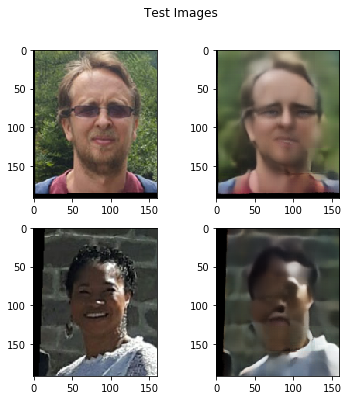

Epoch: 16 Gen Train Loss: 3.801811695098877 MSE Loss: 2.3630154728889465 KLD Loss: 0.0 GAN XE Loss: 1.438796192407608 Disc Train Loss: 0.47432006150484085 Test Loss: 2.1989190578460693 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 0.9880952822665373


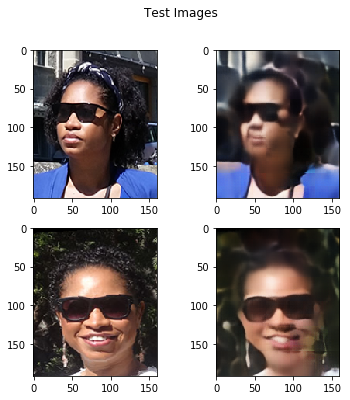

Epoch: 17 Gen Train Loss: 3.834308385848999 MSE Loss: 2.301181435585022 KLD Loss: 0.0 GAN XE Loss: 1.5331269204616547 Disc Train Loss: 0.48015785217285156 Test Loss: 2.22704154253006 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 1.0000000447034836


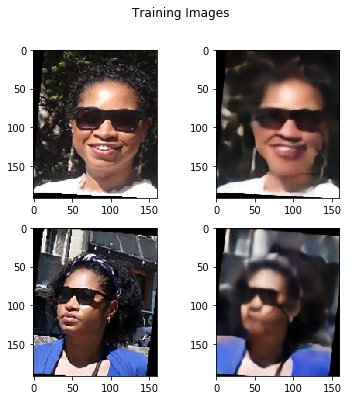

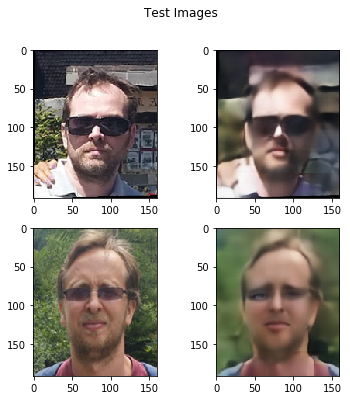

Epoch: 18 Gen Train Loss: 3.7863887548446655 MSE Loss: 2.283206284046173 KLD Loss: 0.0 GAN XE Loss: 1.50318244099617 Disc Train Loss: 0.578919991850853 Test Loss: 2.274921476840973 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 1.0000000447034836


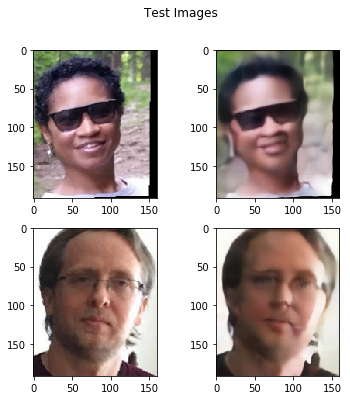

Epoch: 19 Gen Train Loss: 3.6828105449676514 MSE Loss: 2.2253957390785217 KLD Loss: 0.0 GAN XE Loss: 1.4574147760868073 Disc Train Loss: 0.5336566641926765 Test Loss: 2.29981791973114 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 0.9880952822665373


Epoch: 20 Gen Train Loss: 3.5838778018951416 MSE Loss: 2.21212375164032 KLD Loss: 0.0 GAN XE Loss: 1.3717540502548218 Disc Train Loss: 0.47659432888031006 Test Loss: 2.242628335952759 Avg Tr Disc Acc: 0.9761905198295912 Avg Te Disc Acc: 1.0000000447034836


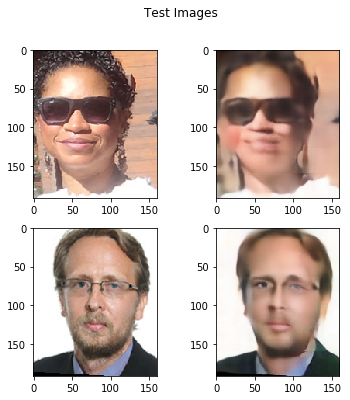

Epoch: 21 Gen Train Loss: 3.766905426979065 MSE Loss: 2.3048078417778015 KLD Loss: 0.0 GAN XE Loss: 1.4620975255966187 Disc Train Loss: 0.5479612424969673 Test Loss: 2.1813820004463196 Avg Tr Disc Acc: 0.9523809949556986 Avg Te Disc Acc: 1.0000000447034836


Epoch: 22 Gen Train Loss: 3.8491657972335815 MSE Loss: 2.276896297931671 KLD Loss: 0.0 GAN XE Loss: 1.5722694396972656 Disc Train Loss: 0.3917711079120636 Test Loss: 2.290380358695984 Avg Tr Disc Acc: 1.0000000447034836 Avg Te Disc Acc: 0.9880952822665373
Copying file://model_3g.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

In [20]:
train_discriminator(discriminator, generator, train_loader2, d_optimizer, g_optimizer, test_loader=train_loader2, num_epochs=15, print_metrics=1000, extra_gen_train=2, plot_images=2000, train_gen=True, train_disc=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

#### Additional Training on Specific Images

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")